# Subreddit Stats

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict

## Parameters

In [2]:
start_epoch = int(datetime.datetime(2018, 1, 1).timestamp())
start_subs = 680       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
max_posts = 10000      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl

## Get Data

In [3]:
class Comment:
    def __init__(self):
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''

class Post:
    def __init__(self):
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''

In [4]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
subcount = SortedDict()
posts = []
prev_info_len = 1

for i, post_id in enumerate(post_ids):
    submission = praw.models.Submission(r, id=post_id)
    ts = int(submission.created_utc)
    subcount[ts] = id2subs[post_id.id]
    submission.comments.replace_more()
    comment_ids = submission.comments.list()
    c = []
    
    for comment_id in comment_ids:
        comment = praw.models.Comment(r, id=comment_id)
        temp = Comment()
        temp.body = comment.body
        temp.author = comment.author
        temp.ts = comment.created_utc
        temp.score = comment.score
        temp.url = comment.permalink
        c.append(temp)
    
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    temp = Post()
    temp.title = submission.title
    temp.author = submission.author
    temp.ts = submission.created_utc
    temp.score = submission.score
    temp.comments = c
    temp.url = submission.permalink
    posts.append(temp)
    
    title = (temp.title[:47] + '...') if len(temp.title) > 47 else temp.title
    info = '%05d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)
    
num_posts = i+1
    
print('\ndone')

KeyboardInterrupt: 

## Visualize Data

### Subscriber Growth

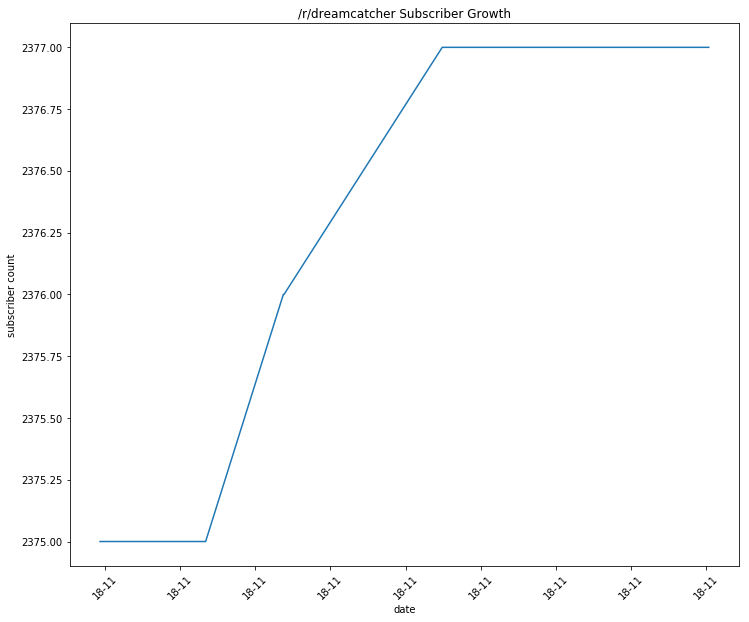

In [5]:
timestamps = np.zeros(len(subcount))
subs = np.zeros(len(subcount))
no_sub_data_end = -1
for i, ts in enumerate(subcount):
    timestamps[i] = ts
    subs[i] = subcount[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
    
if start_subs is not None:
    if no_sub_data_end < len(subs)-1:
        subs[:no_sub_data_end+1] = np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1)
        
for i in range(no_sub_data_end):
    subcount[timestamps[i]] = subs[i]
    
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.show()

### Top Posts

In [6]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, post in enumerate(posts):
    ts = int(post.ts)
    adj_scores[i] = (float(post.score) / subcount[ts])


top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    post = posts[idx]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (float(post.score) / subcount[int(post.ts)]))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.url))
    print()

top post #1
title:          Yoohyeon and Charmander
author:         SpideyCyclist
time:           2018-11-17 08:00:23
score:          52
adjusted score: 0.021876
comments:       4
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xupx2/yoohyeon_and_charmander/

top post #2
title:          Screenshots of the new Dreamcatcher official site
author:         SpideyCyclist
time:           2018-11-16 13:45:14
score:          50
adjusted score: 0.021053
comments:       6
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xma1u/screenshots_of_the_new_dreamcatcher_official_site/

top post #3
title:          The sun shines in the warm light
author:         kyunikeon
time:           2018-11-16 19:22:10
score:          44
adjusted score: 0.018526
comments:       3
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xp9kl/the_sun_shines_in_the_warm_light/

top post #4
title:          Hasta la vista, Nightmare Hunter and Spider
author:         SpideyCyclist
time

### Top Comments

In [7]:
all_comments = []
comment_ts2post_ts = {}
for i, post in enumerate(posts):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
        if comment.ts not in comment_ts2post_ts:
            comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i in range(len(all_comments)):
    ts = int(all_comments[i].ts)
    adj_scores[i] = float(all_comments[i].score) / subcount[comment_ts2post_ts[ts]]
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.url))
    print()

top comment #1
comment:        For example mine is that I knew about Dreamcatcher ever since Chase Me, but.. the MV's prevented ...
author:         vagabond2787
time:           2018-11-17 08:50:43
score:          10
adjusted score: 0.004207
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xuy4c/what_are_your_dreamcatcher_confessions/e9vb7va/

top comment #2
comment:        I couldn't tell SuA and Siyeon apart for like a month during Good Night era...
author:         ipwnmice
time:           2018-11-17 09:06:11
score:          8
adjusted score: 0.003366
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xuy4c/what_are_your_dreamcatcher_confessions/e9vbpnv/

top comment #3
comment:        1. My embarrassment is that I can't choose who my bias is. I love every single one of them. They ...
author:         kyunikeon
time:           2018-11-17 12:16:44
score:          8
adjusted score: 0.003366
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9xuy4c/

### Top Users

In [30]:
users = OrderedDict()
for i, post in enumerate(posts):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += (float(post.score) / subcount[ts])
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += (float(comment.score) / subcount[ts])
        users[comment.author]['comments'] += 1

#### Top Posters

In [31]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 8
total score:           193
total adjusted score:  0.081222

top poster #2
user:                  kyunikeon
total number of posts: 1
total score:           44
total adjusted score:  0.018526

top poster #3
user:                  vagabond2787
total number of posts: 1
total score:           12
total adjusted score:  0.005048

top poster #4
user:                  ipwnmice
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #5
user:                  internet0jesus
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #6
user:                  durogamon
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #7
user:                  Vipr0
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #8
user:                  BlackLegendZz
total number of posts: 0
tot

#### Top Commenters

In [32]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      19
total comment score:           65
total adjusted comment score:  0.027357

top commenter #2
user:                          vagabond2787
total number of comments:      11
total comment score:           39
total adjusted comment score:  0.016409

top commenter #3
user:                          internet0jesus
total number of comments:      8
total comment score:           24
total adjusted comment score:  0.010099

top commenter #4
user:                          MetallicCats
total number of comments:      9
total comment score:           22
total adjusted comment score:  0.009257

top commenter #5
user:                          kyunikeon
total number of comments:      6
total comment score:           21
total adjusted comment score:  0.008837

top commenter #6
user:                          Vipr0
total number of comments:      3
total comment score:           15
total adjusted comment score:  0

#### Misc

In [33]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [34]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

for i, key in enumerate(sorted_avg_posters):
    if i >= 10:
        break
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()

top avg poster #1
user:                  kyunikeon
avg adjusted score:    0.018526
total number of posts: 1
total score:           44
total adjusted score:  0.018526

top avg poster #2
user:                  SpideyCyclist
avg adjusted score:    0.010153
total number of posts: 8
total score:           193
total adjusted score:  0.081222

top avg poster #3
user:                  vagabond2787
avg adjusted score:    0.005048
total number of posts: 1
total score:           12
total adjusted score:  0.005048

top avg poster #4
user:                  ipwnmice
avg adjusted score:    0.000000
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top avg poster #5
user:                  internet0jesus
avg adjusted score:    0.000000
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top avg poster #6
user:                  durogamon
avg adjusted score:    0.000000
total number of posts: 0
total score:           0
total adjusted score: 

In [35]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_avg_posters):
    if i >= 10:
        break
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_posters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()

top avg commenter #1
user:                         SgtKwan
avg adjusted comment score:   0.002526
total number of comments:     1
total comment score:          6
total adjusted comment score: 0.002526

top avg commenter #2
user:                         AshamedWerewolf
avg adjusted comment score:   0.002525
total number of comments:     1
total comment score:          6
total adjusted comment score: 0.002525

top avg commenter #3
user:                         Vipr0
avg adjusted comment score:   0.002104
total number of comments:     3
total comment score:          15
total adjusted comment score: 0.006311

top avg commenter #4
user:                         durogamon
avg adjusted comment score:   0.002103
total number of comments:     1
total comment score:          5
total adjusted comment score: 0.002103

top avg commenter #5
user:                         Vasilevskiy
avg adjusted comment score:   0.002103
total number of comments:     2
total comment score:          10
total adjusted c